# Selecting a Model

The goal of this notebook is to choose the best model for predicting scores of NCAA Tournament games. We will use the training data to run several machine learning models for our data. Finally, using the results, we select a modle to use for our NCAA Tournament predictions.

In [1]:
# Import packages
import sys
sys.path.append('../../')

import datetime
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import collegebasketball as cbb
cbb.__version__

'0.3'

## Load the Data

First, we need to load the training data. This data set was built by creating feature vectors, removing games that don't accurately represent the NCAA Tournament games and reducing the number of features to a manageable number. More information about how this was done can be found in the Creating the Training Data, Covariate Shift Analysis and Feature Reduction notebooks.

In [60]:
# Load the csv files that contain the scores/kenpom data
path = '../../Data/Training/training_feat_reduced.csv'
training = pd.read_csv(path)
season = cbb.filter_tournament(training, drop=True)
march = cbb.filter_tournament(training)
exclude_cols = ['Favored', 'Underdog', 'Year', 'Tournament', 'Label']

# Get a sense for the size of each data set
print('Games in training data: {}'.format(len(training)))
print('Regular season games: {0}, Tournament games: {1}'.format(len(season), len(march)))

Games in training data: 14650
Regular season games: 14050, Tournament games: 600


In [61]:
# Split into train and test sets with an equal proportion of actual tournament games in each
season_train, season_test = train_test_split(season, random_state=77)
march_train, march_test = train_test_split(march, random_state=77)

train = pd.concat([season_train, march_train])
test = pd.concat([season_test, march_test])

print('Games in training set: {}'.format(len(train)))
print('Games in test set: {}'.format(len(test)))

Games in training set: 10987
Games in test set: 3663


## Logistic Regression Tuning

Test with l1 and l2 regularization and different c values

In [6]:
penalties = ['l1', 'l2']
c_values = [0.1, 1, 10, 50, 100]

cl_names = list()
clfs = list()
for p in penalties:
    for c in c_values:
        cl_names.append('log_reg_{0}_{1}'.format(p, c))
        clfs.append(LogisticRegression(penalty=p, C=c, solver='liblinear', random_state=77))

cbb.cross_val(train, exclude_cols, clfs, cl_names)

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,log_reg_l1_0.1,0.302714,0.340249,0.307851,0.320487,0.294235,0.313107
1,log_reg_l1_1,0.365759,0.371957,0.364694,0.345296,0.353488,0.360239
2,log_reg_l1_10,0.364341,0.377176,0.372361,0.345560,0.363299,0.364547
3,log_reg_l1_50,0.363636,0.378119,0.372361,0.349084,0.368178,0.366276
4,log_reg_l1_100,0.363636,0.378119,0.372004,0.349421,0.366327,0.365902
5,log_reg_l2_0.1,0.305931,0.326784,0.319672,0.304663,0.289133,0.309237
6,log_reg_l2_1,0.364356,0.368473,0.359726,0.340216,0.349953,0.356545
7,log_reg_l2_10,0.377691,0.375969,0.365759,0.345967,0.366512,0.366379
8,log_reg_l2_50,0.378537,0.374156,0.364694,0.350097,0.367688,0.367034
9,log_reg_l2_100,0.381413,0.376812,0.369942,0.345631,0.364815,0.367723


In [7]:
cbb.cross_val(train, exclude_cols, clfs, cl_names, scoring='roc_auc')

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,log_reg_l1_0.1,0.724025,0.699240,0.691655,0.702440,0.694534,0.702379
1,log_reg_l1_1,0.728627,0.708164,0.703997,0.700754,0.698454,0.707999
2,log_reg_l1_10,0.728233,0.708317,0.704799,0.700142,0.698375,0.707973
3,log_reg_l1_50,0.728160,0.709280,0.704842,0.699778,0.698279,0.708068
4,log_reg_l1_100,0.728132,0.709298,0.704845,0.699714,0.698397,0.708077
5,log_reg_l2_0.1,0.720457,0.695317,0.691627,0.701052,0.688896,0.699470
6,log_reg_l2_1,0.728528,0.706925,0.703481,0.701667,0.696334,0.707387
7,log_reg_l2_10,0.728579,0.707850,0.704614,0.699892,0.697004,0.707588
8,log_reg_l2_50,0.728820,0.708269,0.704568,0.699576,0.696844,0.707615
9,log_reg_l2_100,0.728501,0.708050,0.705009,0.699637,0.696961,0.707632


In [8]:
clf_l2 = LogisticRegression(penalty='l2', C=10, solver='liblinear', random_state=77)
clf_l1 = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state=77)
cbb.evaluate(season_train, march_train, exclude_cols, [clf_l2, clf_l1], ['L2 Penalty', 'L1 Penalty'])

,Classifier,Precision,Recall,F1,AUC,Brier,Accuracy
0,L2 Penalty,0.500000,0.229358,0.314465,0.734779,0.163327,0.757778
1,L1 Penalty,0.490196,0.229358,0.312500,0.732008,0.164102,0.755556


## Random Forest Tuning

In [9]:
min_samples_splits = [2, 5, 10]
max_depths = [None, 25, 15]
max_features = ['sqrt', 'log2', 10]

cl_names = list()
clfs = list()
for s in min_samples_splits:
    for d in max_depths:
        for f in max_features:
            cl_names.append('rf_{0}_{1}_{2}'.format(s, d, f))
            clfs.append(RandomForestClassifier(min_samples_split=s, max_depth=d, max_features=f, 
                                               n_jobs=-1, random_state=77))

cross_val_result = cbb.cross_val(train, exclude_cols, clfs, cl_names)
cross_val_result

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,rf_2_None_sqrt,0.286229,0.288952,0.246068,0.257353,0.282741,0.272269
1,rf_2_None_log2,0.284404,0.274510,0.242537,0.260223,0.267951,0.265925
2,rf_2_None_10,0.294380,0.297911,0.271493,0.289331,0.290076,0.288638
3,rf_2_25_sqrt,0.296029,0.303309,0.246296,0.283623,0.275261,0.280904
4,rf_2_25_log2,0.256030,0.273585,0.250464,0.258364,0.287958,0.265280
5,rf_2_25_10,0.298748,0.302703,0.264253,0.284946,0.291312,0.288392
6,rf_2_15_sqrt,0.261860,0.269231,0.253788,0.254302,0.241224,0.256081
8,rf_2_15_10,0.269017,0.293785,0.257223,0.250235,0.286964,0.271445
9,rf_5_None_sqrt,0.285453,0.296846,0.260073,0.271809,0.268864,0.276609
10,rf_5_None_log2,0.287020,0.278937,0.253968,0.273234,0.264286,0.271489


In [10]:
cross_val_result = cbb.cross_val(train, exclude_cols, clfs, cl_names, scoring='roc_auc')
cross_val_result

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,rf_2_None_sqrt,0.583219,0.578023,0.563581,0.575799,0.569615,0.574047
1,rf_2_None_log2,0.574070,0.574218,0.564014,0.573498,0.568083,0.570777
2,rf_2_None_10,0.587131,0.585429,0.566011,0.580062,0.579026,0.579532
3,rf_2_25_sqrt,0.582238,0.580288,0.567896,0.584942,0.573205,0.577714
4,rf_2_25_log2,0.576208,0.572988,0.561838,0.575822,0.567494,0.570870
5,rf_2_25_10,0.585999,0.582534,0.563105,0.581093,0.577645,0.578075
6,rf_2_15_sqrt,0.598159,0.596776,0.584242,0.597314,0.579315,0.591161
7,rf_2_15_log2,0.606509,0.599328,0.583712,0.597333,0.584062,0.594189
8,rf_2_15_10,0.605062,0.604182,0.586051,0.597718,0.588239,0.596250
9,rf_5_None_sqrt,0.588708,0.590060,0.574135,0.582570,0.575038,0.582102


In [92]:
clf_2_None_10 = RandomForestClassifier(n_estimators=500, min_samples_split=2, max_depth=None, max_features=10, random_state=77)
clf_2_25_10 = RandomForestClassifier(n_estimators=500, min_samples_split=2, max_depth=25, max_features=10, random_state=77)
clf_5_None_10 = RandomForestClassifier(n_estimators=500, min_samples_split=5, max_depth=None, max_features=10, random_state=77)
clf_10_25_10 = RandomForestClassifier(n_estimators=500, min_samples_split=10, max_depth=25, max_features=10, random_state=77)
clf_5_None_sqrt = RandomForestClassifier(n_estimators=500, min_samples_split=5, max_depth=None, max_features='sqrt', random_state=77)
clf_10_15_sqrt = RandomForestClassifier(n_estimators=500, min_samples_split=10, max_depth=15, max_features='sqrt', random_state=77)

clfs = [clf_2_None_10, clf_2_25_10, clf_5_None_10, clf_10_25_10, clf_5_None_sqrt, clf_10_15_sqrt]
cl_names = ['rf_2_None_10', 'rf_2_25_10', 'rf_5_None_10', 'rf_10_25_10', 'rf_5_None_sqrt', 'rf_10_15_sqrt']
cbb.evaluate(season_train, march_train, exclude_cols, clfs, cl_names)

## Taking a Look at an XGBoost Model

In [25]:
clf = XGBClassifier(n_estimators=500, use_label_encoder=False, eval_metric='logloss', random_state=77)
cbb.cross_val(train, exclude_cols, [clf], ['XGBoost'])

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,XGBoost,0.333874,0.343671,0.313433,0.338141,0.350797,0.335983


In [26]:
cbb.cross_val(train, exclude_cols, [clf], ['XGBoost'], scoring='roc_auc')

,Classifier,Run 1,Run 2,Run 3,Run 4,Run 5,Average
0,XGBoost,0.587354,0.589086,0.57667,0.580571,0.584555,0.583647


In [28]:
cbb.evaluate(season_train, march_train, exclude_cols, [clf], ['XGBoost'])

,Classifier,Precision,Recall,F1,AUC,Brier,Accuracy
0,XGBoost,0.318182,0.256881,0.284264,0.649358,0.227215,0.686667


## Selecting a ML Model

Next, we will train the models and test them using the march data to select a ML model that can best predict upsets in the NCAA Tournament for each training data set. We will be choosing between  Decision Tree, Random Forest and Logistic Regression. We will be using classifiers from scikit learn.

In [32]:
# Create the models
log = LogisticRegression(penalty='l2', C=10, solver='liblinear', random_state=77)
rf = RandomForestClassifier(n_estimators=500, max_depth=25, max_features=10, random_state=77)
xgb = XGBClassifier(n_estimators=500, use_label_encoder=False, eval_metric='logloss', random_state=77)

clfs = [log, rf, xgb]
cl_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

cbb.evaluate(season, march, exclude_cols, clfs, cl_names)

,Classifier,Precision,Recall,F1,AUC,Brier,Accuracy
0,Logistic Regression,0.549296,0.250000,0.343612,0.741713,0.166534,0.751667
1,Random Forest,0.391304,0.173077,0.240000,0.680888,0.183794,0.715000
2,XGBoost,0.386792,0.262821,0.312977,0.668933,0.221983,0.700000


In [125]:
cv_results, log_data = cbb.leave_march_out_cv(season, march, exclude_cols, log)
cv_results

,Precision,Recall,F1,AUC,Brier,Accuracy
Classifier,,,,,,
2010,0.285714,0.125000,0.173913,0.686198,0.174717,0.703125
2011,0.444444,0.210526,0.285714,0.664474,0.197571,0.701493
2012,0.700000,0.411765,0.518519,0.788235,0.153985,0.805970
2013,0.666667,0.235294,0.347826,0.735294,0.166909,0.776119
2014,1.000000,0.291667,0.451613,0.856589,0.164499,0.746269
2015,0.500000,0.285714,0.363636,0.716981,0.150936,0.791045
2016,0.300000,0.214286,0.250000,0.650943,0.172578,0.731343
2017,0.800000,0.235294,0.363636,0.791765,0.150621,0.791045
2018,0.500000,0.222222,0.307692,0.758503,0.163731,0.731343


In [126]:
cv_results, rf_data = cbb.leave_march_out_cv(season, march, exclude_cols, rf)
cv_results

,Precision,Recall,F1,AUC,Brier,Accuracy
Classifier,,,,,,
2010,0.333333,0.062500,0.105263,0.699219,0.171951,0.734375
2011,0.500000,0.210526,0.296296,0.631579,0.204803,0.716418
2012,0.625000,0.294118,0.400000,0.728235,0.169946,0.776119
2013,0.333333,0.176471,0.230769,0.594118,0.210633,0.701493
2014,0.909091,0.416667,0.571429,0.840116,0.169989,0.776119
2015,0.500000,0.214286,0.300000,0.700809,0.159999,0.791045
2016,0.200000,0.142857,0.166667,0.551213,0.195736,0.701493
2017,0.300000,0.176471,0.222222,0.737647,0.174721,0.686567
2018,0.400000,0.111111,0.173913,0.690476,0.177947,0.716418


In [127]:
cv_results, xgb_data = cbb.leave_march_out_cv(season, march, exclude_cols, xgb)
cv_results

,Precision,Recall,F1,AUC,Brier,Accuracy
Classifier,,,,,,
2010,0.111111,0.062500,0.080000,0.587240,0.258958,0.640625
2011,0.400000,0.315789,0.352941,0.630482,0.244535,0.671642
2012,0.500000,0.235294,0.320000,0.702353,0.186709,0.746269
2013,0.166667,0.117647,0.137931,0.565882,0.273225,0.626866
2014,0.866667,0.541667,0.666667,0.818798,0.164514,0.805970
2015,0.363636,0.285714,0.320000,0.756065,0.168023,0.746269
2016,0.200000,0.214286,0.206897,0.540431,0.249757,0.656716
2017,0.307692,0.235294,0.266667,0.712941,0.230898,0.671642
2018,0.500000,0.222222,0.307692,0.699546,0.197052,0.731343


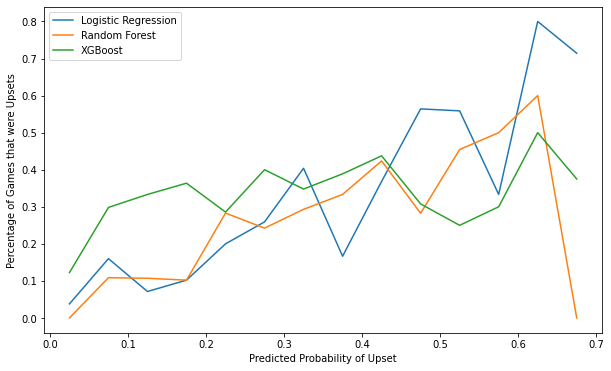

In [141]:
probs = [log_data['Probability'], rf_data['Probability'], xgb_data['Probability']]
probability_graph_new(data_with_predictions['Label'], probs, cl_names)

The results above show that the Logistic Regression Model on just the Kenpom works best. For now, we will just use this model with this data set. In the future, I plan to use multiple models on each of these different data sets weighted by thier performance, but for now we will just use this model.